# Validation
This file tests the models against the test set.

# Setup

In [1]:
import pandas as pd
import numpy as np

In [111]:
def num_to_incorrect_udc(prediction, truth):
    num_correct = 0
    for i in range(len(prediction)):
        try:
            if prediction[i] == truth[i]:
                num_correct += 1
            else:
                return num_correct
        except IndexError:
            # If the prediction is longer than the truth, we assume all predictions are correct
            return len(truth)
    return num_correct


In [84]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
class MultiLabelClassifier:
    """
    A class to standardize KNN model handling.
    """

    def __init__(self, model_dict):
        """
        model_dict: A dictionary where keys are model names and values are the trained models + encoders (unpickled).
        """
        self.models = model_dict

    def predict(self, X, debug_count=100):
        """
        Predicts labels for input X
        Returns a list of each model. It assumes that models are loaded consecutively.
        """
        predictions = []

        if isinstance(X, list):
            i = 0
            for title_desc in X:
                current_text_prediction = []
                for model_name, (model, encoder) in self.models.items():
                    prediction = model.predict([title_desc])
                    labeled_prediction = encoder.inverse_transform(prediction)
                    if labeled_prediction == 'no_value':
                        labeled_prediction = r'@'
                    current_text_prediction.append(labeled_prediction[0])
                i += 1
                if i % debug_count == 0:
                    print(f'Processed {i} texts')
                predictions.append(current_text_prediction)
            return predictions
                    




        for model_name, (model, encoder) in self.models.items():
            prediction = model.predict(X)
            #print(model)
            labeled_prediction = encoder.inverse_transform(prediction)
            if labeled_prediction == 'no_value':
                labeled_prediction = r'@' # As there is no @ in UDC, we use it to represent no value
                # Instead of just using no_value, because our num_to_incorrect_udc function expects a string of digits
            predictions.append(labeled_prediction[0])
        return predictions

    def predict_probability(self, X):
        """
        Predicts probabilities for input X
        Returns a list of each model. It assumes that models are loaded consecutively.
        """
        probabilities = []
        if isinstance(X, list):
            for title_desc in X:
                current_text_probabilities = []
                for model_name, (model, encoder) in self.models.items():
                    prediction_proba = model.predict_proba([title_desc])
                    max_proba = prediction_proba.max(axis=1)
                    current_text_probabilities.append(max_proba[0])
                probabilities.append(current_text_probabilities)
            return probabilities


        for model_name, (model, encoder) in self.models.items():
            prediction_proba = model.predict_proba(X)
            max_proba = prediction_proba.max(axis=1)
            probabilities.append(max_proba[0])
        return probabilities


In [83]:
def get_scores(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }

# Setup

## KNN Models

### Sep-KNN
Sep-KNN is our 9 models ensemble.

In [ ]:
# Sets up our model-encoder dictionary
knn_model_dir = 'knn'
knn_model_dict = {}
for i in range(0, 10):
    model_path = f'{knn_model_dir}/knn_value_{i}.pkl'
    encoder_path = f'{knn_model_dir}/labelencoder_value_{i}.pkl'

    model = pd.read_pickle(model_path)
    encoder = pd.read_pickle(encoder_path)

    knn_model_dict[i] = (model, encoder)


    

In [ ]:
knn_model_sep_complete = MultiLabelClassifier(knn_model_dict) # Loads into our MultiLabelClassifier class

### Example Usage

In [ ]:
knn_model_sep_complete.predict(['History of Aerial Photogrammetry and Remote Sensing.'])


['5', '2', '8', '6', '6', ':', '@', '2', '@', '@']

In [22]:
knn_model_sep_complete.predict_probability(['History of Aerial Photogrammetry and Remote Sensing.'])

[np.float64(1.0),
 np.float64(1.0),
 np.float64(0.6666666666666666),
 np.float64(0.3333333333333333),
 np.float64(0.6666666666666666),
 np.float64(0.6666666666666666),
 np.float64(0.6666666666666666),
 np.float64(0.6666666666666666),
 np.float64(0.6666666666666666),
 np.float64(0.6)]

## STD KNN
STD-KNN is our single model, with pruned codes.

In [ ]:
# Sets up our model-encoder dictionary
std_knn_model_path = 'std_knn/std_pruning_knn_model.pkl'
std_knn_model = pd.read_pickle(std_knn_model_path)
std_knn_label_encoder_path = 'std_knn/std_pruning_label_encoder.pkl'
std_knn_label_encoder = pd.read_pickle(std_knn_label_encoder_path)

std_knn_model_dict = {
    0: (std_knn_model, std_knn_label_encoder)
    }


In [ ]:
# Loads into our MultiLabelClassifier class
std_unpruned = MultiLabelClassifier(std_knn_model_dict)


### Example Usage

In [38]:
std_unpruned.predict(['History of Aerial Photogrammetry and Remote Sensing.'])

['5288']

## Bert model

In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
bert_path = 'bert'
tokenizer_bert = AutoTokenizer.from_pretrained(bert_path)
model_bert = AutoModelForSequenceClassification.from_pretrained(bert_path)

In [ ]:
class BertClassifier:
    """
    A class to standardize BERT model handling.
    """
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def predict(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1)
        return predicted_class.item()

### Example Usage

In [45]:
bert_model_class = BertClassifier(model_bert, tokenizer_bert)
bert_model_class.predict(['History of Aerial Photogrammetry and Remote Sensing.'])

782

## T5 model

In [47]:
from transformers import AutoModelForSeq2SeqLM

In [49]:
t5_path = 't5'
t5_tokenizer = AutoTokenizer.from_pretrained(t5_path)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_path)
t5_model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
class t5Seq2seq:
    """
    A class to standardize T5 model handling.
    """
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def predict(self, text, **kwargs):
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = self.model.generate(**inputs, **kwargs)
        decoded_output = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return decoded_output

### Example Usage

In [ ]:
example_prompt = """
Whispers of Dixie Clay"" delves into the rich tapestry of Alabama's cultural and linguistic heritage, capturing the unique voices, dialects, and stories embedded in the region's soil. Through vivid narratives and authentic dialogue, the book brings to life the spirit of Dixie, exploring the deep connections between language, identity, and place in Alabama.
"""

In [ ]:
t5_model_class = t5Seq2seq(t5_model, t5_tokenizer)
t5_model_class.predict([example_prompt],
 max_length=50, num_beams=4, early_stopping=True)

'1e(728.821.2)'

# Testing

## Data preparation

In [65]:
import numpy as np

In [66]:
test_array = np.load('test_idx.npy')

In [68]:
df = pd.read_csv('udc_dataset_no_duplicate_titles.csv')


In [70]:
df[' udc_1']

0        1¢(533.22)
1        1¢(533.22)
2        1¢(533.22)
3        1¢(533.22)
4        1¢(533.22)
            ...    
37368     621.6.065
37369     621.6.065
37370     621.6.065
37371     621.6.065
37372     621.6.065
Name:  udc_1, Length: 37373, dtype: object

In [74]:
y_test_periods = df[' udc_1'].iloc[test_array]
y_test_no_periods = df[' udc_1'].str.replace('.', '', regex=False).iloc[test_array]

In [75]:
x_test = df['generated_title'] + ' ' + df['generated_description']
x_test = x_test.iloc[test_array]
x_test.head()

18729    Strategies and Technologies in Modern Anti-Air...
9632     Spatial Analysis of Environmental Impact Facto...
10031    Spatial Distribution and Socioeconomic Impact ...
3640     Advanced Formulation and Dermatological Effect...
20885    Molecular Mechanisms and Regulation of Apospor...
dtype: object

### Evaluations

#### Std KNN

In [80]:
knn_std_predictions = std_unpruned.predict(x_test.tolist())

In [91]:
y_test_no_periods_pruned = y_test_no_periods.apply(lambda x: x[:4])
y_test_no_periods_pruned

18729    6237
9632     1e(7
10031    7122
3640     6655
20885    5811
         ... 
4209     0051
11060    6213
1122     0696
26673    5758
33557    6234
Name:  udc_1, Length: 7475, dtype: object

In [ ]:
std_scores = get_scores(knn_std_predictions, y_test_no_periods_pruned)
print(f"Standard KNN Scores: {std_scores}")

c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [109]:
def num_to_incorrect_udc(prediction, truth):
    print(prediction)
    num_correct = 0
    for i in range(len(prediction)):
        try:
            if prediction[i] == truth[i]:
                num_correct += 1
            else:
                return num_correct
        except IndexError:
            # If the prediction is longer than the truth, we assume all predictions are correct
            return len(truth)
    
    return num_correct


In [113]:
std_knn_num_to_incorrect = []
for i, prediction in enumerate(knn_std_predictions):
    num_incorrect = num_to_incorrect_udc(prediction[0], y_test_no_periods.to_list()[i])
    std_knn_num_to_incorrect.append(num_incorrect)


In [ ]:
mean_std_knn_num_to_incorrect = np.mean(std_knn_num_to_incorrect)
print(f"mean_std_knn_num_to_incorrect: {mean_std_knn_num_to_incorrect}")


np.float64(3.3819397993311036)

#### Bert

In [123]:
bert_model_class.predict('Goodbye')

782

In [115]:
bert_predictions = [bert_model_class.predict(text) for text in x_test.tolist()]
bert_predictions

[782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782,
 782

In [126]:
bert_predictions_str = pd.Series(bert_predictions).astype(str)

In [ ]:
bert_scores = get_scores(bert_predictions_str, y_test_no_periods_pruned)
print(f"BERT Scores: {bert_scores}")


c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.0, 'f1_score': 0.0, 'precision': 0.0, 'recall': 0.0}

There is clearly something wrong with the Bert model, so we won't even test for num_to_incorrect_udc().

### seq2seq

In [128]:
t5_predictions = [t5_model_class.predict(text) for text in x_test.tolist()]
t5_predictions

['623.423',
 '1e(739.821.2)',
 '631.031',
 '615.263',
 '591.5',
 '616.88-008.438',
 '544.44',
 '729.7.02',
 '1e(739.825.1)',
 '616-007.31',
 '343.22',
 '161.2',
 '636.013',
 '355.022.2',
 '591.5',
 '636.013',
 '599.23',
 '1e(729.82)',
 '341.32',
 '615.15',
 '561.1',
 '669.423',
 '7.031.2',
 '661.5',
 '623.423.22',
 '1e(729.82)',
 '004.42',
 '623.423',
 '582.82',
 '599.428',
 '669.7',
 '621.3.014.3',
 '1e(492.21)',
 '591.5',
 '1e(239.4)',
 '616.8-008.4',
 '598.4',
 '616-007.31',
 '1e(491.21)',
 '1e(729.82)',
 '796.091.2',
 '544.44',
 '004.42',
 '1e(729.82)',
 '629.7.02',
 '549.4',
 '1e(821.2)',
 '544.7.02',
 '791.5',
 '799.4',
 '52-52',
 '1e(729.81)',
 '659.8',
 '1e(872.21)',
 '623.442',
 '547.522.4',
 '599.4',
 '549.828',
 '547.473',
 '1e(239.4)',
 '165.32',
 '681.3.014.3',
 '343.22',
 '621.94',
 '1e(569.8)',
 '547.522.4',
 '341.331.3',
 '544.44',
 '539.4',
 '661.52',
 '539.4',
 '539.2',
 '347.828',
 '623.423',
 '539.4',
 '669.7.02',
 '659.8',
 '621.3.014.3',
 '615.253',
 '661.553',
 '

In [ ]:
t5_scores = get_scores(t5_predictions, y_test_no_periods_pruned)
print(t5_scores)

c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\wrimp\Documents\UDC2\.conda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.0, 'f1_score': 0.0, 'precision': 0.0, 'recall': 0.0}

It does not make sense to test T5 with our standard evaluation. As such, num_to_incorrect_udc() is better:

In [ ]:
t5_num_to_incorrect = []
for i, prediction in enumerate(t5_predictions):
    num_incorrect = num_to_incorrect_udc(prediction, y_test_no_periods.to_list()[i])
    t5_num_to_incorrect.append(num_incorrect)
mean_t5_num_to_incorrect = np.mean(t5_num_to_incorrect)
print(f"mean_t5_num_to_incorrect: {mean_t5_num_to_incorrect}")


np.float64(1.9847491638795987)

### knn separated

In [143]:
knn_sep_predictions = knn_model_sep_complete.predict(x_test.tolist(), debug_count=100)
knn_sep_predictions

Processed 100 texts
Processed 200 texts
Processed 300 texts
Processed 400 texts
Processed 500 texts
Processed 600 texts
Processed 700 texts
Processed 800 texts
Processed 900 texts
Processed 1000 texts
Processed 1100 texts
Processed 1200 texts
Processed 1300 texts
Processed 1400 texts
Processed 1500 texts
Processed 1600 texts
Processed 1700 texts
Processed 1800 texts
Processed 1900 texts
Processed 2000 texts
Processed 2100 texts
Processed 2200 texts
Processed 2300 texts
Processed 2400 texts
Processed 2500 texts
Processed 2600 texts
Processed 2700 texts
Processed 2800 texts
Processed 2900 texts
Processed 3000 texts
Processed 3100 texts
Processed 3200 texts
Processed 3300 texts
Processed 3400 texts
Processed 3500 texts
Processed 3600 texts
Processed 3700 texts
Processed 3800 texts
Processed 3900 texts
Processed 4000 texts
Processed 4100 texts
Processed 4200 texts
Processed 4300 texts
Processed 4400 texts
Processed 4500 texts
Processed 4600 texts
Processed 4700 texts
Processed 4800 texts
P

[['6', '2', '3', '7', '6', '2', '@', '@', '@', '@'],
 ['1', 'e', '(', '7', '3', '5', '2', '1', '8', '4'],
 ['1', '1', '(', '2', '8', '@', '1', '@', '@', '@'],
 ['6', '6', '5', '5', '8', '5', '9', '@', '@', '@'],
 ['5', '8', '1', '1', '6', '3', '@', '@', '@', '@'],
 ['6', '1', '7', '7', '5', '1', '6', '@', '@', '@'],
 ['5', '1', '4', '1', '0', '0', '2', '2', '@', '@'],
 ['3', '9', '7', '5', '@', '@', '@', '@', '@', '@'],
 ['1', 'e', '(', '7', '3', '4', '9', '1', '7', '6'],
 ['6', '1', '6', '2', '4', '-', '0', '0', '3', '6'],
 ['3', '4', '3', '2', '5', '6', '@', '@', '@', '@'],
 ['1', '7', '0', '1', '8', '2', '@', '@', '@', '@'],
 ['6', '1', '2', '3', '9', '2', '8', '@', '@', '@'],
 ['3', '5', '5', '3', '1', '@', '@', '@', '@', '@'],
 ['1', '3', '(', '0', '1', '2', '@', ')', '@', '@'],
 ['6', '3', '6', '0', '8', '5', '4', '@', '@', '@'],
 ['5', '5', '1', '4', '3', '5', '1', '6', '@', '@'],
 ['1', 'e', '(', '7', '2', '3', '4', ')', '@', '@'],
 ['3', 'd', '(', '0', '0', '7', '4', ')', '@',

As with the T5 model, it does not make sense to test the separated KNN with our standard evaluation. As such, only num_to_incorrect_udc() is tested:

In [144]:
knn_sep_num_to_incorrect = []
for i, prediction in enumerate(knn_sep_predictions):
    num_incorrect = num_to_incorrect_udc(prediction, y_test_no_periods.to_list()[i])
    knn_sep_num_to_incorrect.append(num_incorrect)
mean_knn_sep_num_to_incorrect = np.mean(knn_sep_num_to_incorrect)

In [ ]:
print(f"mean_knn_sep_num_to_incorrect: {mean_knn_sep_num_to_incorrect}")

np.float64(5.505284280936455)

# Exporting knn model classes

In [2]:
import pickle

In [ ]:
# Export std_knn dict:
with open("std_knn_dict.json", "w") as f:
    pickle.dump(std_knn_model_dict, f)

with open("knn_sep_dict.json", "w") as f:
    pickle.dump(knn_model_dict, f)





### Exporting results

In [ ]:
results_dict = {}
results_dict['std_knn'] = {
    'mean_num_to_incorrect': mean_std_knn_num_to_incorrect,
    'scores': std_scores
}

results_dict['bert'] = {
    'mean_num_to_incorrect': 0,
    'scores': bert_scores
}

results_dict['t5'] = {
    'mean_num_to_incorrect': mean_t5_num_to_incorrect}

results_dict['knn_sep'] = {
    'mean_num_to_incorrect': mean_knn_sep_num_to_incorrect}

In [153]:
with open('results_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

# Visualization

In [17]:
# Assuming a new session:
# If results_dict is not declared:
with open('results_dict.pkl', 'rb') as f:
    results_dict = pickle.load(f)

results_dict['bert']['mean_num_to_incorrect'] = 0 # Fixing as I saved it wrong before

### Accuracy scores

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
results_dict['std_knn']['scores']

{'accuracy': 0.8020066889632107,
 'f1_score': 0.799150698688876,
 'precision': 0.8220609534251311,
 'recall': 0.8020066889632107}

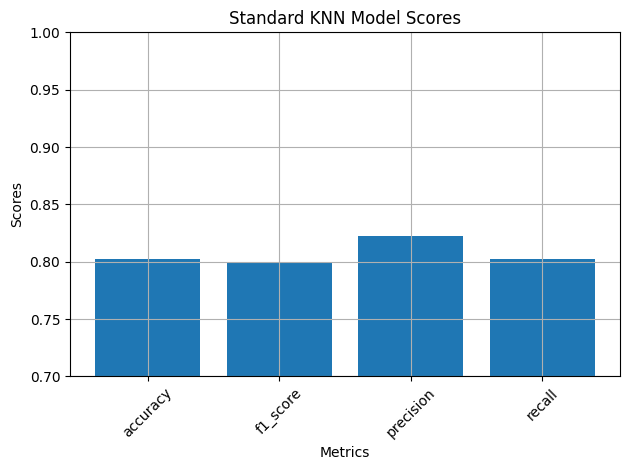

In [15]:
fig, ax = plt.subplots()


labels = results_dict['std_knn']['scores'].keys()
values = results_dict['std_knn']['scores'].values()

ax.bar(labels, values)

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.ylim(0.7, 1.0)
plt.title('Standard KNN Model Scores')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

## num_to_incorrect_udc

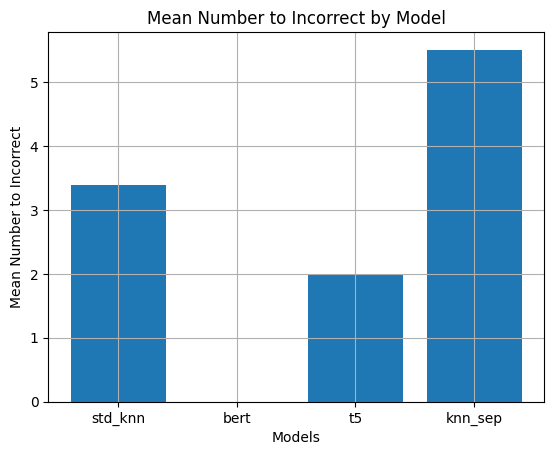

In [19]:
fig, ax = plt.subplots()
labels = results_dict.keys()
values = [results_dict[key]['mean_num_to_incorrect'] for key in labels]

ax.bar(labels, values)
plt.grid()
plt.xlabel('Models')
plt.ylabel('Mean Number to Incorrect')
plt.title('Mean Number to Incorrect by Model')
plt.show()
